In [1]:
import h5py
import scipy
import scipy.misc
import glob
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
plt.ion()

In [3]:
camfiles = glob.glob('./comma-dataset/camera/*.h5')
logfiles = glob.glob('./comma-dataset/log/*.h5')


In [4]:
#create an empty space to store data
all_imgs = np.zeros((1,3,64,64),dtype=np.uint8)
spds = np.zeros(1)
accel = np.zeros(1)
steer = np.zeros(1)
gas = np.zeros(1)
brake = np.zeros(1)

In [5]:
fstarts = [0] #location of start frame

In [6]:
for cam, log in zip(camfiles, logfiles):
    cams = h5py.File(cam, 'r')["X"]
    
    #count the amount of data in the file
    nframes = len(cams) #number of frames in each camera h5 file
    abs_start = fstarts[-1] #start at the first frame of each file
    abs_end = abs_start + nframes #end at the first frame + number of frames
    fstarts.append(abs_end) #the end frame of each file
    
    #strip down cams to 64x64
#     smcam = np.zeros((nframes,3,64,64),dtype=np.uint8)
    smcam = np.zeros((nframes,64,64,3),dtype=np.uint8)
    for i, c in tqdm(enumerate(cams)):
        smcam[i] = scipy.misc.imresize(c[:,:,:],(64, 64), 'cubic', 'RGB')#.transpose((1,2,0))
        
    logs = h5py.File(log, 'r')
    ptrs1 = logs['cam1_ptr'].value
#     ptrs2 = logs['cam2_ptr'].value
    
    #line logs up to correct frames
    starts = np.zeros(nframes, dtype=np.uint32)
    starts[0] = 37 #up to frame 37 is just backing out of driveway
    cur = 1
    for i, p in enumerate(ptrs1):
        if int(p) == cur:
            starts[cur] = i
            cur += 1
            
    #make room for new data
#     all_imgs.resize((abs_end, 3, 64, 64))
    all_imgs.resize((abs_end,64, 64, 3))
    spds.resize((abs_end))
    accel.resize((abs_end))
    steer.resize((abs_end))
    gas.resize((abs_end))
    brake.resize((abs_end))
    
    #stuff data into large array
    all_imgs[abs_start:abs_end] = smcam
    accel[abs_start:abs_end] = logs['car_accel'].value[starts]
    spds[abs_start:abs_end] = logs['speed'].value[starts]
    steer[abs_start:abs_end] = logs['steering_angle'].value[starts]
    gas[abs_start:abs_end] = logs['gas'].value[starts]
    brake[abs_start:abs_end] = logs['brake'].value[starts]

25865it [00:41, 617.28it/s]
85296it [02:28, 574.08it/s]
78463it [02:26, 535.25it/s]
56166it [01:53, 495.78it/s]
52722it [01:50, 477.45it/s]
30538it [00:57, 529.50it/s]
51691it [01:43, 500.10it/s]
18177it [00:35, 509.89it/s]
19731it [00:39, 504.31it/s]
44792it [01:29, 503.06it/s]
58993it [02:07, 463.46it/s]


(3, 160, 320)


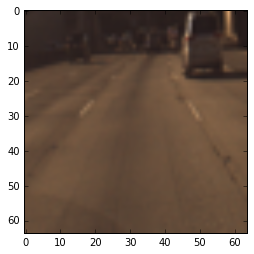

In [9]:
print(cams[3].shape)
# plt.imshow(np.transpose(cams[3], (1,2,0)))
# plt.imshow(scipy.misc.imresize(cams[1000],(64, 64), 'cubic', 'RGB'))#.transpose((2,1,0)))
plt.imshow(all_imgs[8000])

In [10]:
# scale
spds = (spds - np.min(spds))/(np.max(spds)-np.min(spds))
accel = (accel - np.min(accel))/(np.max(accel)-np.min(accel))
steer = (steer - np.min(steer))/(np.max(steer)-np.min(steer))
gas = (gas - np.min(gas))/(np.max(gas)-np.min(gas))
brake = (brake - np.min(brake))/(np.max(brake)-np.min(brake))

In [ ]:
tqdm(np.savez('simple_data.npz',
        imgs=all_imgs,
        spds=spds,
        accel=accel,
        steer=steer,
        gas=gas,
        brake=brake,
        idx = np.array(fstarts)))